# Deliveroo Test

In [1]:
# Importing spark tools
import findspark
findspark.init()
import pyspark

# Importing stats tools
from sklearn.model_selection import train_test_split

# Importing plotting tools
#!python3 -m pip install matplotlib
#!python3 -m pip install seaborn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

rand_seed = 1234


In [2]:
#spark.stop()

In [3]:
# Setting up Spark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = pyspark.SparkContext(conf=conf)
spark = (SparkSession.builder.master("local")
          .appName("deliverootest")
          .getOrCreate()
)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # for dataframes to display nicely

22/04/08 15:12:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# loading data
ordersDF = spark.read.csv("data/orders.csv", header="true", inferSchema="false")
restaurantsDF = spark.read.csv("data/restaurants.csv", header="true", inferSchema="true")
# merging both csv files on restaurant_id
df = ordersDF.join(restaurantsDF, on='restaurant_id', how='left')
df_raw = df
display(df)

restaurant_id,order_acknowledged_at,order_ready_at,order_value_gbp,number_of_items,prep_time_seconds,country,city,type_of_food
1326,2015-06-01 12:28:...,2015-06-01 14:12:...,59.9,2,6220,UK,London,burritos
1326,2015-06-06 17:06:...,2015-06-06 17:16:...,24.0,8,603,UK,London,burritos
1326,2015-06-08 14:56:...,2015-06-08 15:03:...,15.25,3,443,UK,London,burritos
1326,2015-06-12 15:12:...,2015-06-12 15:23:...,28.05,8,669,UK,London,burritos
255,2015-06-01 13:07:...,2015-06-01 14:02:...,56.3,7,3314,UK,London,chinese
255,2015-06-01 21:01:...,2015-06-01 21:19:...,18.2,3,1049,UK,London,chinese
255,2015-06-01 21:04:...,2015-06-01 21:29:...,43.2,4,1468,UK,London,chinese
255,2015-06-01 21:47:...,2015-06-01 22:09:...,35.8,4,1300,UK,London,chinese
255,2015-06-01 22:11:...,2015-06-01 22:32:...,30.0,3,1254,UK,London,chinese
255,2015-06-03 13:17:...,2015-06-03 14:44:...,168.2,13,5209,UK,London,chinese


### Cleaning the data

In [5]:
#Removing Duplicates
n_duplicates = df.count() - df.distinct().count()
df = df.distinct()
print("Removed {} duplicates.".format(n_duplicates))

Removed 0 duplicates.


In [6]:
#Describing the columns
display(df.describe())
df.printSchema()

summary,restaurant_id,order_acknowledged_at,order_ready_at,order_value_gbp,number_of_items,prep_time_seconds,country,city,type_of_food
count,32394,32394,32394,32394,32394,32394,32394,32394,32394
mean,1290.5555349756128,null,null,26.547303009260975,4.025714638513305,1299.9938568870778,null,null,null
stddev,960.2955041718736,null,null,19.263851130972757,2.392062707266787,4404.573190785395,null,null,null
min,10,2015-06-01 10:34:...,2015-06-01 13:13:...,0.5,1,0,France,Berlin,american
max,999,2015-07-01 14:10:...,2015-07-01 22:43:...,99.9,9,999,UK,Southampton,vietnamese


root
 |-- restaurant_id: string (nullable = true)
 |-- order_acknowledged_at: string (nullable = true)
 |-- order_ready_at: string (nullable = true)
 |-- order_value_gbp: string (nullable = true)
 |-- number_of_items: string (nullable = true)
 |-- prep_time_seconds: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- type_of_food: string (nullable = true)



In [7]:
# Checking for missing data
from pyspark.sql.functions import isnan
missing_values = "'nan', 'unknown', 'NULL', '', 'null', '', 'n/a'"
for c in df.columns:
    df_missing_num = df.filter("{} is null or lower({}) in ({})".format(c, c, missing_values)).count()
    print("N missing values from column {} : {}".format(c, df_missing_num))

N missing values from column restaurant_id : 0
N missing values from column order_acknowledged_at : 0
N missing values from column order_ready_at : 0
N missing values from column order_value_gbp : 0
N missing values from column number_of_items : 0
N missing values from column prep_time_seconds : 0
N missing values from column country : 0
N missing values from column city : 0
N missing values from column type_of_food : 0


In [8]:
# Enforcing types
from pyspark.sql.types import *
from pyspark.sql.functions import *

df = (df_raw
    .withColumn("restaurant_id", col("restaurant_id").cast(IntegerType()))
    .withColumn("order_acknowledged_at", col("order_acknowledged_at").cast(TimestampType()))
    .withColumn("order_month", month(col("order_acknowledged_at")))
    .withColumn("order_dayofweek", dayofweek(col("order_acknowledged_at")))
    .withColumn("order_hour", hour(col("order_acknowledged_at")))
    .withColumn("order_value_gbp", col("order_value_gbp").cast(DoubleType()))
    .withColumn("number_of_items", col("number_of_items").cast(IntegerType()))
    .withColumn("prep_time_seconds", col("prep_time_seconds").cast(IntegerType()))
    .withColumn("country", lower(col("country")))
    .withColumn("city", lower(col("city")))
    .withColumn("type_of_food", lower(col("type_of_food")))
    .drop("order_ready_at")
    .drop("order_acknowledged_at")
)
display(df)
df.printSchema()

restaurant_id,order_value_gbp,number_of_items,prep_time_seconds,country,city,type_of_food,order_month,order_dayofweek,order_hour
1326,59.9,2,6220,uk,london,burritos,6,2,12
1326,24.0,8,603,uk,london,burritos,6,7,17
1326,15.25,3,443,uk,london,burritos,6,2,14
1326,28.05,8,669,uk,london,burritos,6,6,15
255,56.3,7,3314,uk,london,chinese,6,2,13
255,18.2,3,1049,uk,london,chinese,6,2,21
255,43.2,4,1468,uk,london,chinese,6,2,21
255,35.8,4,1300,uk,london,chinese,6,2,21
255,30.0,3,1254,uk,london,chinese,6,2,22
255,168.2,13,5209,uk,london,chinese,6,4,13


root
 |-- restaurant_id: integer (nullable = true)
 |-- order_value_gbp: double (nullable = true)
 |-- number_of_items: integer (nullable = true)
 |-- prep_time_seconds: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- type_of_food: string (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- order_dayofweek: integer (nullable = true)
 |-- order_hour: integer (nullable = true)



In [9]:
#Categorical variables:
cat_vars = ["country", "city", "type_of_food", "order_month", "order_dayofweek", "order_hour"]
#Numerical vars:
num_vars = ["prep_time_seconds", "order_value_gbp", "number_of_items"]

### Cleaning Numerical vars

Number of restaurants: 1697
Number of orders: 32394
Average number of orders per restaurant: 19.08898055391868
Median number of orders per restaurant: 9.0


Text(0.5, 0, 'Orders per Restaurant')

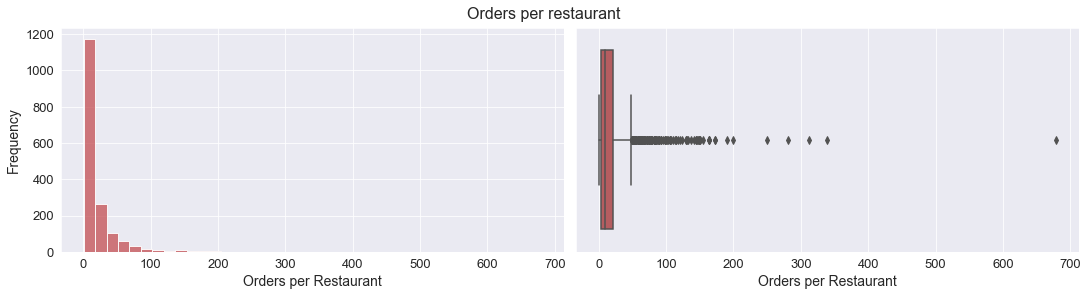

In [10]:
n_restaurants = df.select("restaurant_id").distinct().count()
n_orders = df.distinct().count()
print("Number of restaurants: {}".format(n_restaurants))
print("Number of orders: {}".format(n_orders))
print("Average number of orders per restaurant: {}".format(n_orders/n_restaurants))

df_orders_per_restaurant = df.groupBy("restaurant_id").count().toPandas().set_index("restaurant_id")
print("Median number of orders per restaurant: {}".format(df_orders_per_restaurant["count"].median()))

fig, ax = plt.subplots(1,2,figsize=(15,4), constrained_layout=True)
fig.suptitle("Orders per restaurant", fontsize=16)

sns.histplot(x=df_orders_per_restaurant['count'],color=sns.color_palette("deep")[3], bins=40, ax=ax[0])
ax[0].set_xlabel("Orders per Restaurant")
ax[0].set_ylabel("Frequency")
sns.boxplot(x=df_orders_per_restaurant['count'],color=sns.color_palette("deep")[3], ax=ax[1])
ax[1].set_xlabel("Orders per Restaurant")


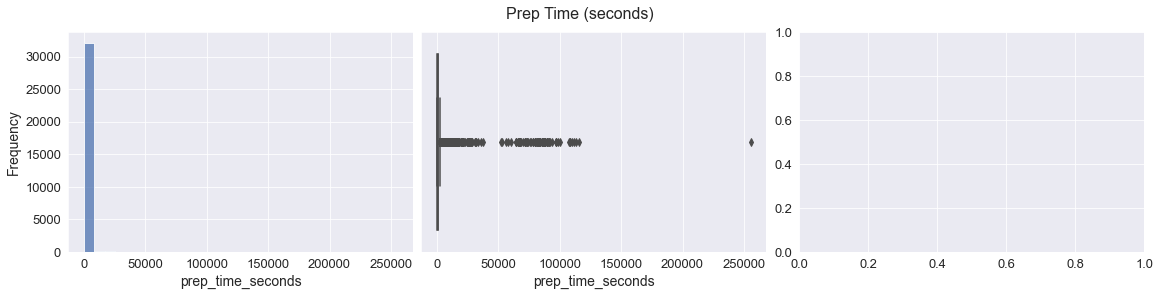

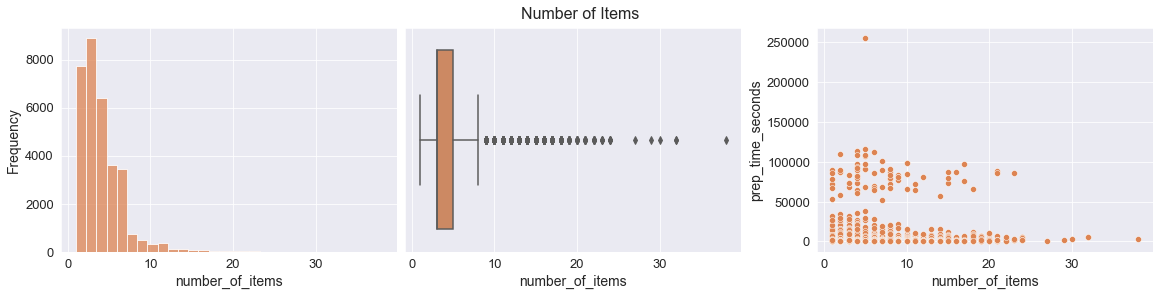

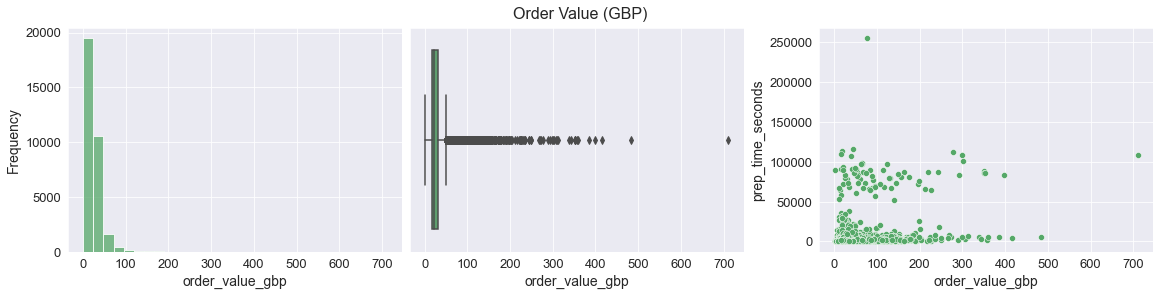

In [11]:
def plotting_numerical_vars(df, indvar, title='', depvar='', colorint=0):
    if depvar != "":
        pd = df.select(indvar, depvar).toPandas()
    else:
        pd = df.select(indvar).toPandas()
    fig, ax = plt.subplots(1,3,figsize=(16,4), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    sns.histplot(x=pd[indvar], color=sns.color_palette("deep")[colorint],bins=30, ax=ax[0])
    ax[0].set_xlabel(indvar)
    ax[0].set_ylabel("Frequency")
    sns.boxplot(x=pd[indvar],color=sns.color_palette("deep")[colorint], ax=ax[1])
    ax[1].set_xlabel(indvar)
    if depvar != '':
        sns.scatterplot(data=pd, y=depvar, x=indvar, color=sns.color_palette("deep")[colorint], ax=ax[2])
        ax[2].set_xlabel(indvar)
        ax[2].set_ylabel(depvar)

plotting_numerical_vars(df=df, title="Prep Time (seconds)", indvar="prep_time_seconds", colorint=0)
plotting_numerical_vars(df=df, title="Number of Items", indvar="number_of_items", depvar="prep_time_seconds", colorint=1)
plotting_numerical_vars(df=df, title="Order Value (GBP)", indvar="order_value_gbp", depvar="prep_time_seconds", colorint=2)


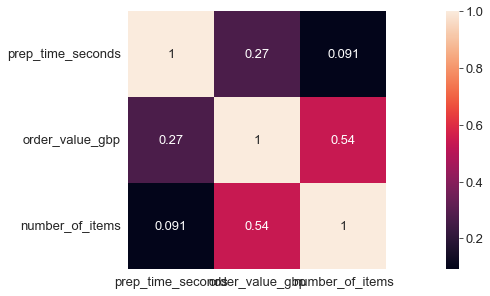

In [12]:
#Checking correlations
pd_numerical = df.select(num_vars).toPandas()

corrs = pd_numerical.corr()

fig, ax = plt.subplots(1,1,figsize=(16,4), constrained_layout=True)
fig.suptitle = "Correlations between numerical variables"
sns.heatmap(corrs, square=True, annot=True)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=0)


In [13]:
# Removing number_of_items variable due to the positive correlation
df = (df
    .drop("number_of_items")
)

num_vars = ["order_value_gbp", "prep_time_seconds"]

## Exploring transformations on numerical Variables
### Normalization
The goal of normalization is to transform features to be on a similar scale. This improves the performance and training stability of the model.

**Min/max scaling** = converting e.g. values ranging from 100 - 900 to 0 - 1
* good for uniform distributions, or values where a min and max value is obvious and has few or no outliers. 

**Feature Clipping** = capping data to a min and max value
* good way to handle extreme outliers, one way to cap is to set it based on max / min * standard deviation.

**Log scaling** = also a type of transformation
* helpful when a handful of your values have many points, while most other values have few points.

**Z-score** = standardising. 
* It’s useful when there are a few outliers, but not so extreme that you need clipping.

**Bucketing** = you group values to distinct intervals and use the group index as a categorical variable
- can be done with equally spaced bins or based on quantiles to get similar number of datapoints in each bucket
- [Bucketing/Binning](https://developers.google.com/machine-learning/data-prep/transform/bucketing)


### Transformations
The goal of transformations is to make the data more gaussian like, which many models handle best. Different approaches can be taken depending on your data
1. Log transform
2. Sqrt transform
3. Nth power transform:
4. Rank transform
    - Advantages: smooths out unusual distributions, less influenced by outliers than scaling methods.
        - extreme values have less weight
    - Disadvantages: distorts correlations and distances within and across features.
5. RankGauss = turn into rank first then into gaussian distribution
    - First step is to assign a linspace to the sorted features from 0..1, then apply the inverse of error function (erfinv) to shape like gaussians, then substract the mean. [source](https://teju85.github.io/ml-glossary/terms/rankgauss.html)
5. Others: absolute value, rounding


Sources: 
- [Google ML Crash Course](https://developers.google.com/machine-learning/data-prep/transform/transform-numeric)
- [catalog of variable transformations to make your model better](https://towardsdatascience.com/catalog-of-variable-transformations-to-make-your-model-works-better-7b506bf80b97)

Note on doing transformations in spark:

In Python, especially when working with sklearn, most of the models can take raw DataFrames as an input for training. In a distributed environment it can be a little more complicated, as we should be using Assemblers to prepare our training data. VectorAssember from Spark ML library is a module that allows to convert numerical features into a single vector that is used by the machine learning models.

Source:[Vectorassembler in Pyspark](https://pyshark.com/vectorassembler-in-pyspark/)

In [14]:
# # Setting up vectorassembler
# from pyspark.ml.feature import VectorAssembler

# def vectorise_variable(df, varnames):
#     for varname in varnames:
#         assembler = VectorAssembler(
#             inputCols=[varname],
#             outputCol=varname + "_vec")
#         df = assembler.transform(df)
#     return df
# display(vectorise_variable(df,["order_value_gbp", "prep_time_seconds"]))

22/04/08 15:12:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


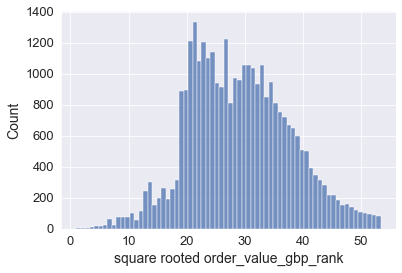

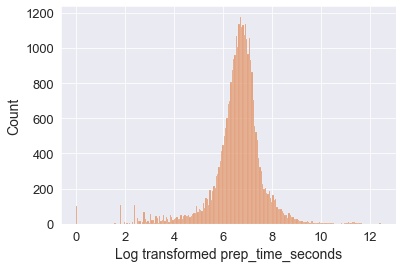

In [15]:
# from pyspark.ml.feature import MinMaxScaler
# from pyspark.ml.functions import vector_to_array

# Transforming the variables
def log_transform(df, varnames, plot=True, colorint=0):
    for varname in varnames:
        df = df.withColumn(varname+"_log", log(col(varname)+ 1)) # Plussing one to avoid log of 0 which is NaN
        if plot:
            sns.histplot(df.select(varname + "_log").toPandas()[varname + "_log"], color=sns.color_palette("deep")[colorint])
            plt.xlabel("Log transformed " + varname)
            plt.show()
    return df

def sqrt_transform(df, varnames, plot=True, colorint=0):
    # n=2 is square root
    for varname in varnames:
        df = df.withColumn(varname+"_sqrt", sqrt(col(varname)))
        if plot:
            sns.histplot(df.select(varname + "_sqrt").toPandas()[varname + "_sqrt"], color=sns.color_palette("deep")[colorint])
            plt.xlabel("square rooted " + varname)
            plt.show()
    return df


def nth_power_transform(df, varnames, n=2, plot=True, colorint=0):
    # n=2 is square root
    for varname in varnames:
        df = df.withColumn(varname+"_nth", power(col(varname), n))
        if plot:
            sns.histplot(df.select(varname + "_nth").toPandas()[varname + "_nth"], color=sns.color_palette("deep")[colorint])
            plt.xlabel("nth (n="+str(n)+") power transformed " + varname)
            plt.show()
    return df

def rank_transform(df, varnames, plot=True, colorint=0):
    from pyspark.sql.window import Window
    # n=2 is square root
    for varname in varnames:
        windowspec = Window.orderBy("order_value_gbp")
        df = df.withColumn(varname+"_rank", dense_rank().over(windowspec)) # note that dense_rank has serious performance issues as it collects to single partition
        if plot:
            sns.histplot(df.select(varname + "_rank").toPandas()[varname + "_rank"], color=sns.color_palette("deep")[colorint])
            plt.xlabel("rank transformed " + varname)
            plt.show()
    return df


sqrt_transform(rank_transform(df,varnames=["order_value_gbp"], plot=False), ["order_value_gbp_rank"])
log_transform(df,varnames=["prep_time_seconds"], colorint=1);

# Wont do the transformations on the dataset until after ive split into train and test

In [16]:
# Normalization
from pyspark.ml.regression import LinearRegression
import pandas as pd
# Standardising:
def standardise(df, varnames, provided_stats = False, stats_input={}):
    newvarnames = []
    df_z = df
    if provided_stats:
        stats = stats_input
    else: 
        stats = {}
    for varname in varnames:
        if not provided_stats:
            df_stats = df.select(
                mean(col(varname)).alias('mean'),
                stddev(col(varname)).alias('stddev')
            ).collect()
            stats[varname] = {"mean": df_stats[0]['mean'], "stddev": df_stats[0]['stddev']}
        average = stats[varname]['mean']
        std = stats[varname]['stddev']
        df_z = (df_z
            .withColumn(varname+"_z", (col(varname) - average)/std)
        )
        newvarnames.append(varname+"_z")

    return df_z, newvarnames, stats

def boxplot_predictors(df, predictors):
    pdf_z = df_z.toPandas()

    #boxplot of predictors
    figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    sns.boxplot(x="variable", y="value", data=pd.melt(pdf_z[predictors]))
    plt.xticks(rotation=50,fontsize = 12)
    plt.title('Boxplot of standardized predictor variables')
    plt.ylabel('value',fontsize=20)
    plt.xlabel('variable',fontsize=20)
    plt.show()

# df_z, z_num_vars, df_stats = standardise(df=df, varnames=num_vars)
# boxplot_predictors(df_z, z_num_vars)


In [17]:

# Estimating outliers
def checkOutliersOverNStdev(df, varnames, N=3, already_standardised=False):
    """Identifies outliers where value is over / under 3 standard deviations around mean"""
    total_outliers = 0
    if not already_standardised:
            df, varnames, df_stats = standardise(df, varnames)
    for varname in varnames:
        outliers = df.filter((col(varname) > 3) | (col(varname) < -3))
        n_outliers = outliers.count()
        total_outliers += n_outliers
        prop_capped = n_outliers/df.count()
        print("Identifying outliers in {0} at {1} SD affects {2} data points, which is {3:.3g}% of the total".format(varname, N, n_outliers, prop_capped*100))
    print("Total outliers is {0}, which is {1:.3g}% of the total".format(total_outliers, (total_outliers/df.count())*100))  


def cappingOutliersOverNStdev(df, varnames, N=3):
    #Removing from dataset
    df_cleaned = df
    for varname in varnames:
        df_cleaned = (df_cleaned
            .withColumn(varname, when(col(varname) > N, lit(N)).otherwise(col(varname)))
            .withColumn(varname, when(col(varname) < (-N), lit((-N))).otherwise(col(varname)))
        )

    return df_cleaned

checkOutliersOverNStdev(df, varnames=num_vars)


# display(df_outliers_null.filter((col("order_value_gbp_z").isNull()) | col("prep_time_seconds_z").isNull()))

# Removing the outliers given its such a small percentage
# df_outliers_not_removed = df # Saving the df before outliers removed
# df = df_outliers_null.na.drop()
# df.drop("prep_time_seconds_z", "order_value_gbp_z")  # We need to re-do transformations/standardisations in the training dataset
# df.describe()


Identifying outliers in order_value_gbp_z at 3 SD affects 487 data points, which is 1.5% of the total
Identifying outliers in prep_time_seconds_z at 3 SD affects 152 data points, which is 0.469% of the total
Total outliers is 639, which is 1.97% of the total


### Exploring categorical vars

Food types: ['latin american', 'rotisserie', 'american / brunch', 'sandwiches', 'sushi', 'lebanese', 'bistro', 'healthy', 'greek', 'russian', 'bbq', 'kosher', 'pan asian', 'sichuan chinese', 'soup', 'korean', 'south american', 'american', 'deli', 'indian', 'german', 'vegan', 'spanish', 'ice cream', 'french', 'diner', 'argentinian', 'vietnamese', 'pizza', 'scottish', 'sans gluten / brunch', 'italian', 'bakery', 'austrian', 'mexican', 'thai', 'mediterranean', 'chinese', 'creperie', 'steakhouse', 'dessert', 'sweet treats', 'seafood', 'thaï / brunch', 'british', 'caribbean', 'north african', 'turkish', 'creole', 'portuguese', 'peruvian', 'irish', 'japanese', 'malaysian', 'chicken', 'persian', 'georgian', 'spanish tapas', 'asian fusion', 'burgers', 'french lebanese', 'middle eastern', 'south indian', 'juices', 'bagels', 'lebanese moroccan', 'nepalese', 'european', 'gluten free', 'modern british', 'australian', 'japanese peruvian', 'taiwanese', 'ethiopian', 'south african', 'ramen', 'interna

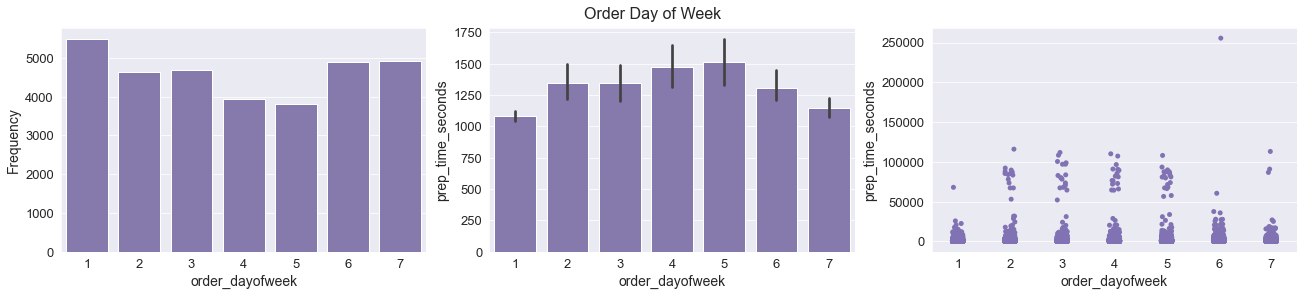

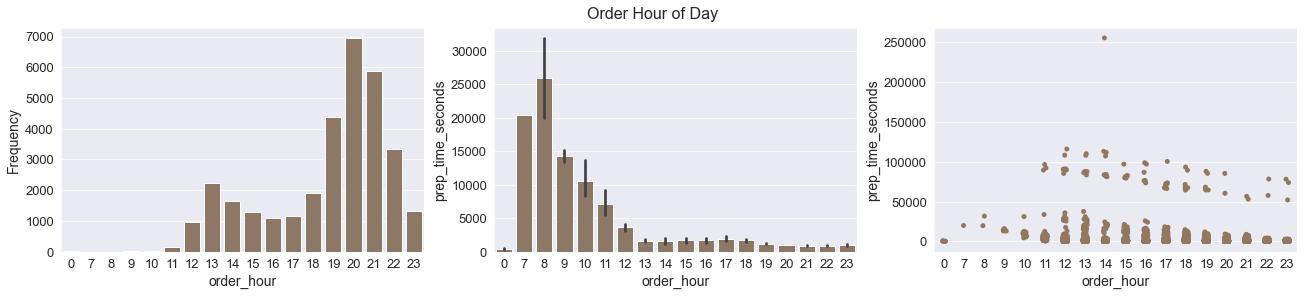

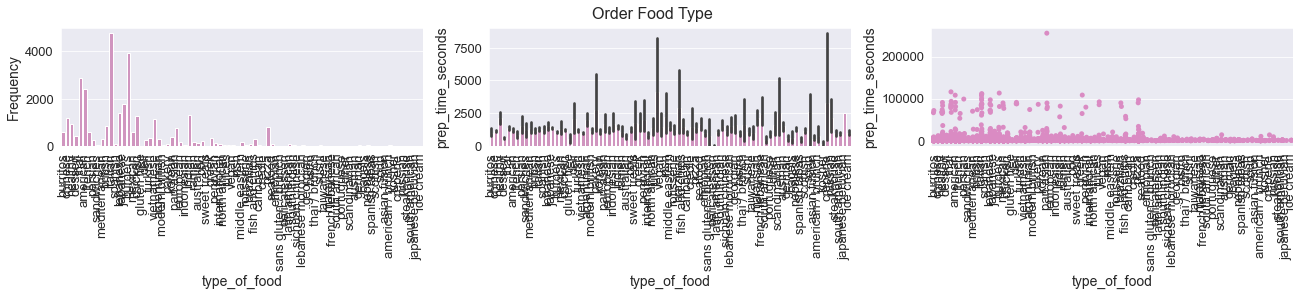

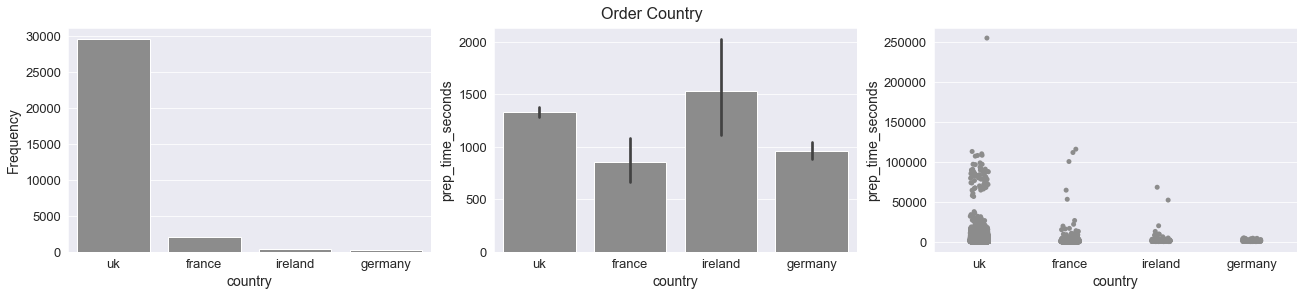

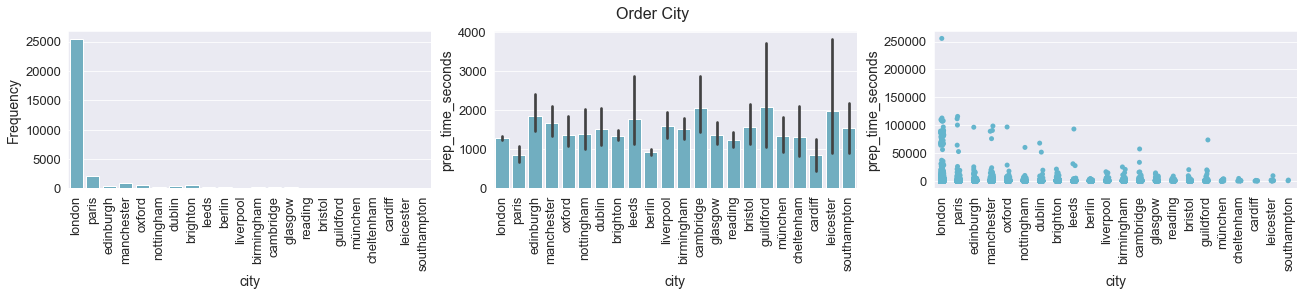

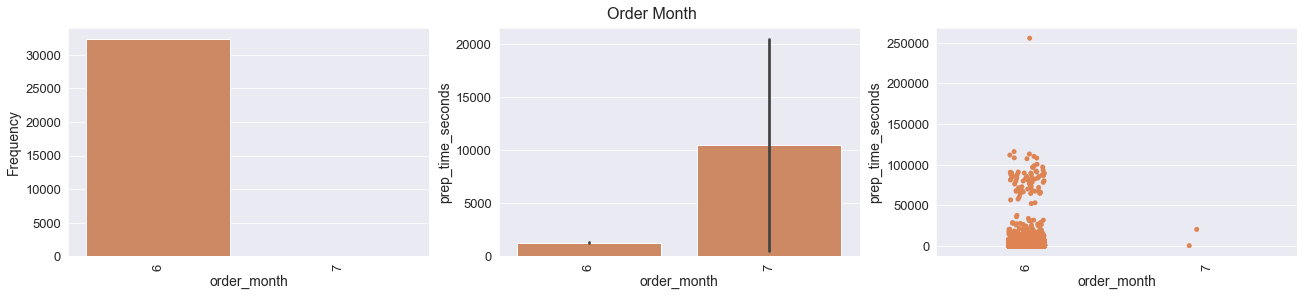

In [18]:
def plotting_categorical_vars(df, indvar, depvar, title='', colorint=0, rotateX=False):
    if depvar != "":
        pd = df.select(indvar, depvar).toPandas()
    else:
        pd = df.select(indvar).toPandas()
    
    fig, ax = plt.subplots(1,3,figsize=(18,4), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    sns.countplot(x=pd[indvar], color=sns.color_palette("deep")[colorint], ax=ax[0])
    ax[0].set_xlabel(indvar)
    if rotateX: ax[0].tick_params(axis='x', rotation=90)
    ax[0].set_ylabel("Frequency")
    sns.barplot(data=pd, x=indvar, y=depvar, color=sns.color_palette("deep")[colorint], ax=ax[1])
    ax[1].set_xlabel(indvar)
    if rotateX: ax[1].tick_params(axis='x', rotation=90)
    ax[1].set_ylabel(depvar)
    sns.stripplot(data=pd, x=indvar, y=depvar, color=sns.color_palette("deep")[colorint], ax=ax[2])
    ax[2].set_xlabel(indvar)
    if rotateX: ax[2].tick_params(axis='x', rotation=90)
    ax[2].set_ylabel(depvar)

# plotting_categorical_vars(df=df_clean, title="Order Month", indvar="order_month", depvar="prep_time_seconds", colorint=3)
plotting_categorical_vars(df=df, title="Order Day of Week", indvar="order_dayofweek", depvar="prep_time_seconds", colorint=4)
plotting_categorical_vars(df=df, title="Order Hour of Day", indvar="order_hour", depvar="prep_time_seconds", colorint=5)
plotting_categorical_vars(df=df, title="Order Food Type", indvar="type_of_food", depvar="prep_time_seconds", colorint=6, rotateX=True)
plotting_categorical_vars(df=df, title="Order Country", indvar="country", depvar="prep_time_seconds", colorint=7)
plotting_categorical_vars(df=df, title="Order City", indvar="city", depvar="prep_time_seconds", colorint=9, rotateX=True)
plotting_categorical_vars(df=df, title="Order Month", indvar="order_month", depvar="prep_time_seconds", colorint=1, rotateX=True)


# Print list of food types
print("Food types: " + str(list(df.select("type_of_food").distinct().toPandas()["type_of_food"])))

In [19]:
# Month only has two values, with july having almost no datapoints, theres no variance in this data so will remove. 
if "order_month" in cat_vars:
    cat_vars.remove("order_month")

We dont really have the domain knowledge to be able to combine the type of food variable to fewer labels. We can however combine levels based on frequency/response rate. 

Red line represents a minimum frequency level of 0.01%
{'city': ['reading',
          'glasgow',
          'berlin',
          'bristol',
          'leicester',
          'southampton',
          'liverpool',
          'nottingham',
          'cambridge',
          'cardiff',
          'münchen',
          'birmingham',
          'leeds',
          'cheltenham',
          'guildford'],
 'country': ['germany'],
 'order_dayofweek': [],
 'order_hour': [9, 8, 7, 10, 11, 0],
 'type_of_food': ['latin american',
                  'rotisserie',
                  'american / brunch',
                  'sandwiches',
                  'sushi',
                  'bistro',
                  'russian',
                  'bbq',
                  'kosher',
                  'sichuan chinese',
                  'soup',
                  'south american',
                  'deli',
                  'german',
                  'vegan',
                  'spanish',
                  'ice cream',
         

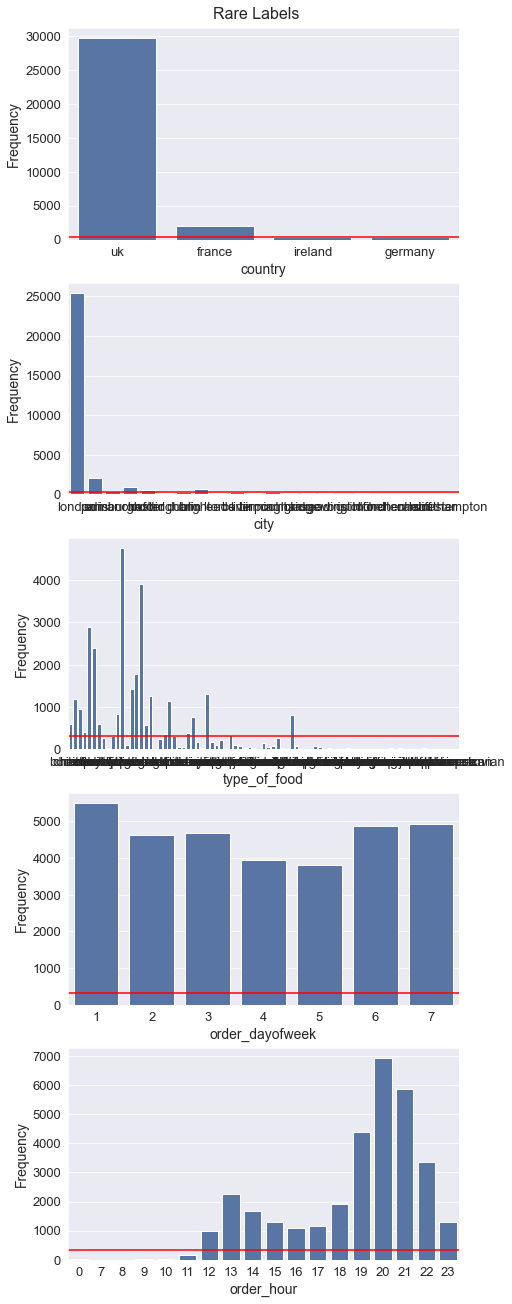

In [20]:
from pprint import pprint
min_freq_prop = 0.01 # Using 1%

def plot_rare_line(df, varnames, min_freq_prop=0.05, colorint=0):
    print("Red line represents a minimum frequency level of {}%".format(min_freq_prop))
    total_freq = df.count()
    min_freq = min_freq_prop*total_freq
    fig, ax = plt.subplots(len(varnames),1,figsize=(7,18), constrained_layout=True)
    fig.suptitle("Rare Labels", fontsize=16)
    pdf= df.toPandas()
    if len(varnames) == 1:
        var = varnames[0]
        sns.countplot(x=pdf[var], color=sns.color_palette("deep")[colorint])
        ax.axhline(min_freq, color="red")
        ax.set_xlabel(var)
        ax.set_ylabel("Frequency")
    else:
        for i in range (0, len(varnames)): 
            var = varnames[i]
            sns.countplot(x=pdf[var], color=sns.color_palette("deep")[colorint], ax=ax[i])
            ax[i].axhline(min_freq, color="red")
            ax[i].set_xlabel(var)
            ax[i].set_ylabel("Frequency")

plot_rare_line(df=df, varnames=cat_vars, min_freq_prop=min_freq_prop)

def get_rare_label_dictionary(df, varnames, min_freq_prop=0.05):
    total_freq = df.count()
    min_freq = min_freq_prop*total_freq
    rare_labels = {}
    for var in varnames:
        rare_labels[var] = list(df.groupby(var).count().filter(col("count")<min_freq).toPandas()[var])
    pprint(rare_labels)
    return rare_labels

rare_labels = get_rare_label_dictionary(df, cat_vars, min_freq_prop=0.01)

def set_rare_labels(df, varnames, rare_labels):
    for varname in varnames:
        if len(rare_labels[varname]) == 0:
            continue
        if len(rare_labels[varname]) > 1:
            df = (df
                .withColumn(varname, when(col(varname).isin(rare_labels[varname]), "rare").otherwise(col(varname)))
            )
        else:
            print("Won't replace label '" + rare_labels[varname][0] + "' because its the only rare label")
    return df

# we wont actually set the rare labels here, wait until train test split. 

Red line represents a minimum frequency level of 0.05%


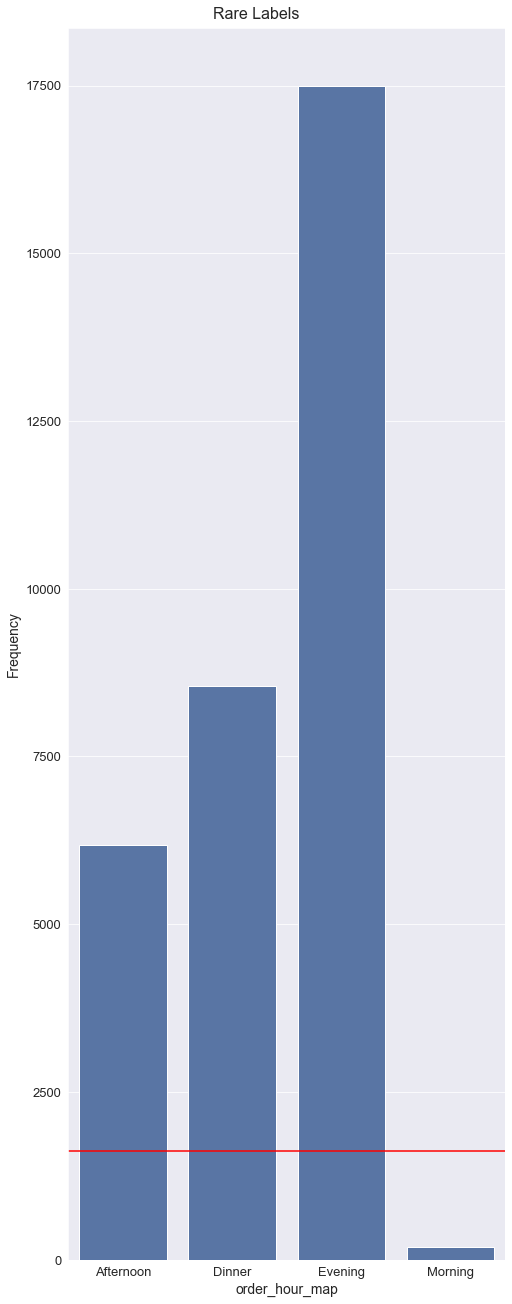

In [21]:
# HOUR: Grouping hours into 4: 8am-12pm, 12pm-4pm, 4-8pm, and 8-12pm, with labels Morning, Afternoon, Dinner, Evening
hour_grouping = {'1': 'Night', '2': 'Night', '3': 'Night', '4': 'Night', '5': 'Night', '6': 'Night', 
                '7': 'Morning', '8': 'Morning', '9': 'Morning', '10': 'Morning', '11': 'Morning', 
                '12': 'Afternoon', '13': 'Afternoon', '14': 'Afternoon', '15': 'Afternoon', 
                '16': 'Dinner', '17': 'Dinner', '18': 'Dinner', '19': 'Dinner', 
                '20': 'Evening', '21': 'Evening', '22': 'Evening', '23': 'Evening', '0': 'Evening'}
df = (df
    .withColumn("order_hour_map", df.order_hour.cast(StringType()))
    .na.replace(to_replace=hour_grouping, subset="order_hour_map")
)
plot_rare_line(df=df, varnames=["order_hour_map"])

# Feature Engineering

First we need to split into train and test data to avoid **Data Leakage** before we do any feature engineering

In [22]:
num_vars = ["prep_time_seconds", "order_value_gbp"]
cat_vars = ["order_hour_map", "city", "country", "type_of_food", "order_dayofweek"]
df_small = df.select(num_vars + cat_vars)

##Split the data into training (70%) and test (30%) data sets so we avoid 
training_df, test_df = df_small.randomSplit([0.7, 0.3], seed=rand_seed)
display(training_df)


prep_time_seconds,order_value_gbp,order_hour_map,city,country,type_of_food,order_dayofweek
0,8.5,Afternoon,london,uk,burgers,2
0,9.2287,Evening,paris,france,french,7
0,10.9,Afternoon,london,uk,burgers,5
0,11.3584,Afternoon,paris,france,american,2
0,11.3584,Dinner,paris,france,mexican,6
0,12.95,Afternoon,london,uk,healthy,3
0,13.65,Dinner,brighton,uk,fish and chips,7
0,14.7,Afternoon,london,uk,burgers,5
0,15.0,Afternoon,london,uk,burritos,5
0,15.0,Evening,london,uk,vietnamese,2


### Transforming and normalizing the numerical variables

22/04/08 15:13:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 15:13:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 15:13:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


{'order_value_gbp_rank_sqrt': {'mean': 27.255516116396016,
                               'stddev': 8.0789036591621},
 'prep_time_seconds_log': {'mean': 6.58644434887423,
                           'stddev': 1.091569454728719}}


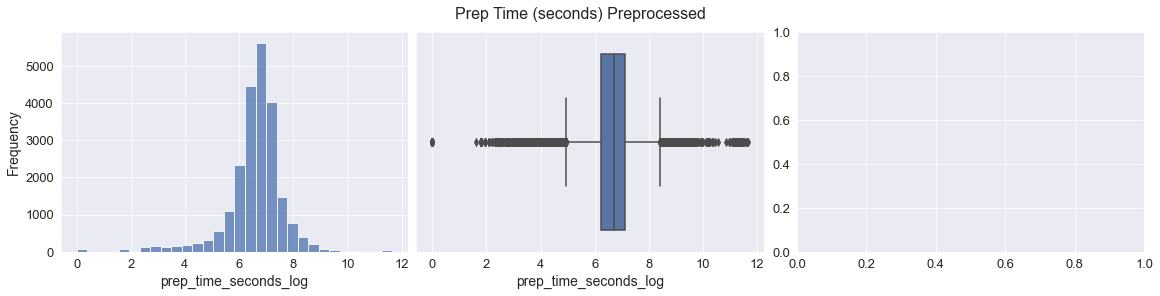

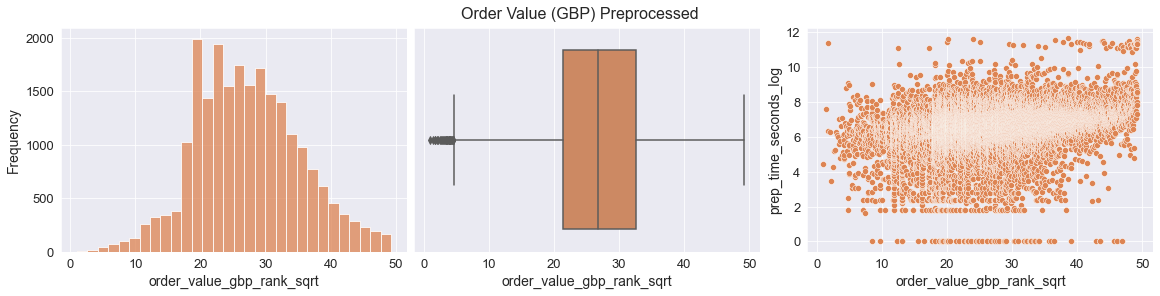

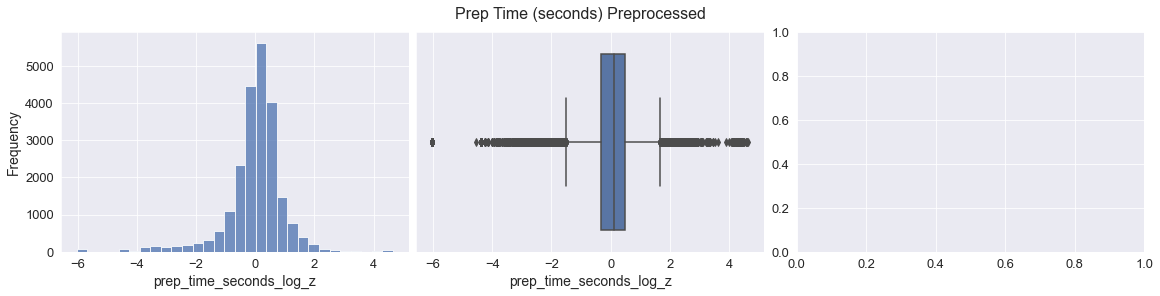

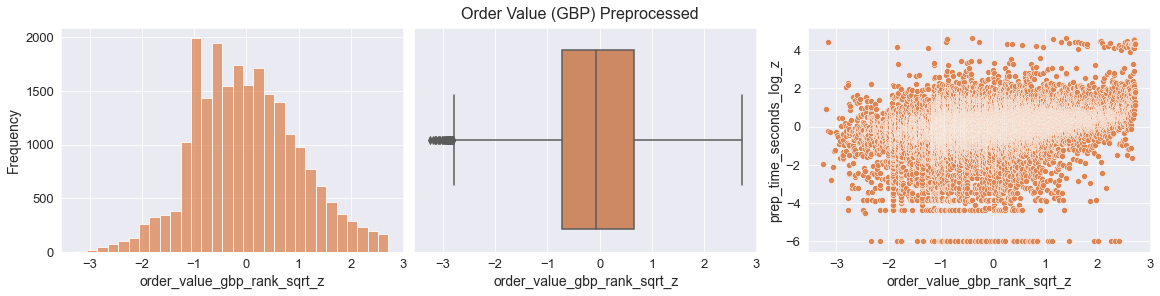

In [23]:
# Doing transformations to get closer to a normal distribution
training_df_preprocessed = sqrt_transform(rank_transform(training_df,varnames=["order_value_gbp"], plot=False), ["order_value_gbp_rank"], plot=False)
training_df_preprocessed = log_transform(training_df_preprocessed,varnames=["prep_time_seconds"], plot=False)
plotting_numerical_vars(df=training_df_preprocessed, title="Prep Time (seconds) Preprocessed", indvar="prep_time_seconds_log", colorint=0)
plotting_numerical_vars(df=training_df_preprocessed, title="Order Value (GBP) Preprocessed", indvar="order_value_gbp_rank_sqrt", depvar="prep_time_seconds_log", colorint=1)


# # Normalising them
training_df_preprocessed, new_varnames, standardised_stats = standardise(df=training_df_preprocessed, varnames=["prep_time_seconds_log", "order_value_gbp_rank_sqrt"], provided_stats=False)

plotting_numerical_vars(df=training_df_preprocessed, title="Prep Time (seconds) Preprocessed", indvar="prep_time_seconds_log_z", colorint=0)
plotting_numerical_vars(df=training_df_preprocessed, title="Order Value (GBP) Preprocessed", indvar="order_value_gbp_rank_sqrt_z", depvar="prep_time_seconds_log_z", colorint=1)

pprint(standardised_stats)

num_vars = ["order_value_gbp_rank_sqrt_z", "prep_time_seconds_log_z"]

### Outliers

22/04/08 15:13:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Identifying outliers in order_value_gbp_rank_sqrt_z at 3 SD affects 10 data points, which is 0.0442% of the total
Identifying outliers in prep_time_seconds_log_z at 3 SD affects 582 data points, which is 2.57% of the total
Total outliers is 592, which is 2.62% of the total


22/04/08 15:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


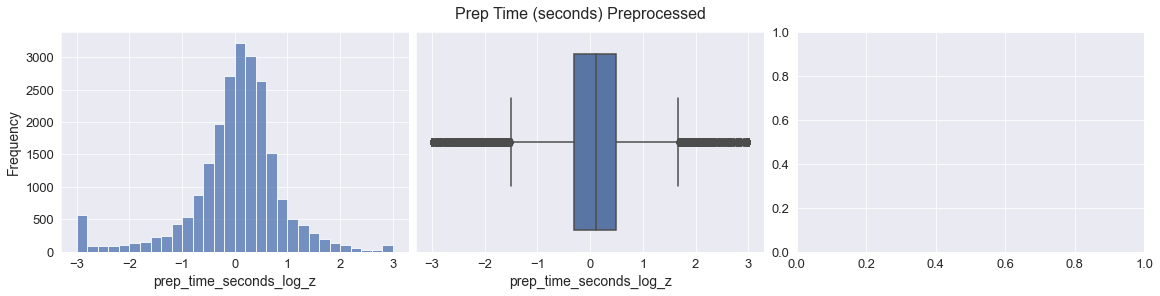

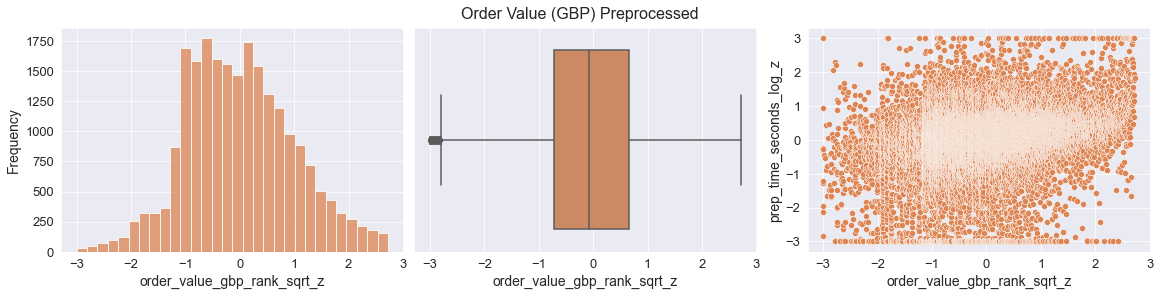

In [24]:
checkOutliersOverNStdev(training_df_preprocessed, varnames=num_vars, already_standardised=True)
training_df_preprocessed = cappingOutliersOverNStdev(training_df_preprocessed, varnames=num_vars)

plotting_numerical_vars(df=training_df_preprocessed, title="Prep Time (seconds) Preprocessed", indvar="prep_time_seconds_log_z", colorint=0)
plotting_numerical_vars(df=training_df_preprocessed, title="Order Value (GBP) Preprocessed", indvar="order_value_gbp_rank_sqrt_z", depvar="prep_time_seconds_log_z", colorint=1)

### Setting rare labels

In [25]:
rare_labels = get_rare_label_dictionary(training_df_preprocessed, cat_vars, min_freq_prop=0.01)
training_df_preprocessed = set_rare_labels(training_df_preprocessed, cat_vars, rare_labels)


#  rare label library: if label is unrecognised its rare

{'city': ['reading',
          'glasgow',
          'berlin',
          'bristol',
          'leicester',
          'southampton',
          'liverpool',
          'nottingham',
          'cambridge',
          'cardiff',
          'münchen',
          'birmingham',
          'leeds',
          'cheltenham',
          'guildford'],
 'country': [],
 'order_dayofweek': [],
 'order_hour_map': ['Morning'],
 'type_of_food': ['latin american',
                  'american / brunch',
                  'rotisserie',
                  'sandwiches',
                  'sushi',
                  'bistro',
                  'russian',
                  'bbq',
                  'kosher',
                  'sichuan chinese',
                  'soup',
                  'south american',
                  'deli',
                  'german',
                  'vegan',
                  'spanish',
                  'ice cream',
                  'diner',
                  'argentinian',
                  

### Encoding categorical variables
1. __Ordinal Encoding__ 
    * For rdinal categorical variables 
    * e.g. {"Short": 0, "Medium": 1, "Long": 2}
2. __One-hot Encoding__
    * for nominal data
    * each label gets a column, with binary encodings (0,1)
    * increases the dimensionality of the data 
    * = _dummy variables_
3. __Hash Encoding__
    * One-way technique - hash encoder output cant be converted back to the input so we lose information
    * should be used for high dimensional data (i.e. lots of labels)
4. __Binary Encoding__
    * combo of hash and one-hot encoding: we its a form of hash encoding but its revertible.
    * good for the case of data with a huge amount of categories.
5. __Base-N Encoding__
    * a base of 2 = binary encoding
    * by increasing the base you get you can reduce the number of dimensions required to encode the variable.
6. __Target Encoding__
    * = converting a categorical value into the mean of the target variable
    * bayesian
    * causes overfitting - the variable will have a hard correlation with the target
    * can only be used during training not test

Source: [analyticsindiamag, A complete guide to categorical encoding](https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/)

The python library `category_encoders` is very useful, see documentation [here](https://contrib.scikit-learn.org/category_encoders/)

In [26]:
import category_encoders as ce

training_df_encoded = training_df_preprocessed.toPandas()

# Saving the string variables in seperate column
for var in cat_vars:
    training_df_encoded[var+"_string"] = training_df_encoded[var]
training_df_encoded["order_hour_map_str"] = training_df_encoded["order_hour_map"]


# Defining the encoders i'd like to use
foodEncoder= ce.BaseNEncoder(cols=['type_of_food'],return_df=True, base=3)

dayOfWeekEncoder= ce.BinaryEncoder(cols=['order_dayofweek'],return_df=True)

hourOfDayEncoder= ce.BinaryEncoder(cols=['order_hour_map'],return_df=True)

countryEncoder= ce.BinaryEncoder(cols=['country'],return_df=True)

cityEncoder= ce.BaseNEncoder(cols=['city'],return_df=True, base=3)


allEncoders = [dayOfWeekEncoder, hourOfDayEncoder, foodEncoder, countryEncoder, cityEncoder]
# What about the dummy variable trap?
##  Instead of using one-hot encoding for the variables with fewer labels, i used binary encoding to avoid the issue of the dummy trap.
# Binary encoding can encode a label, e.g. "Monday" as the combination of 




# Doing the transformations
def encoder_transform(pdf, encoders):
    for encoder in encoders:
        pdf = encoder.fit_transform(pdf) 
    return pdf

training_df_encoded = encoder_transform(training_df_encoded, allEncoders)

def findEncodedVars(columns):
    result = []
    for col in columns:
        if ((col[-2] == "_") | (col[-3] == "_")) and col[-1].isdigit(): result.append(col) 
    return result

encoded_cat_vars = findEncodedVars(training_df_encoded.columns)
print(encoded_cat_vars)
display(training_df_encoded)

22/04/08 15:13:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


['order_hour_map_0', 'order_hour_map_1', 'order_hour_map_2', 'city_0', 'city_1', 'country_0', 'country_1', 'country_2', 'type_of_food_0', 'type_of_food_1', 'type_of_food_2', 'order_dayofweek_0', 'order_dayofweek_1', 'order_dayofweek_2']


,prep_time_seconds,order_value_gbp,order_hour_map_0,order_hour_map_1,order_hour_map_2,city_0,city_1,country_0,country_1,country_2,...,order_value_gbp_rank_sqrt,prep_time_seconds_log,prep_time_seconds_log_z,order_value_gbp_rank_sqrt_z,order_hour_map_string,city_string,country_string,type_of_food_string,order_dayofweek_string,order_hour_map_str
0,86,0.50,0,0,1,0,1,0,0,1,...,1.000000,4.465908,-1.942649,-3.000000,Evening,london,uk,chicken,2,Evening
1,2017,1.10,0,0,1,0,1,0,0,1,...,1.414214,7.609862,0.937565,-3.000000,Evening,london,uk,chicken,6,Evening
2,550,1.50,0,0,1,0,2,0,0,1,...,1.732051,6.311735,-0.251665,-3.000000,Evening,manchester,uk,burgers,4,Evening
3,89652,1.50,0,1,0,0,1,0,0,1,...,1.732051,11.403702,3.000000,-3.000000,Morning,london,uk,mexican,4,Morning
4,520,1.79,0,0,1,0,1,0,0,1,...,2.000000,6.255750,-0.302953,-3.000000,Evening,london,uk,chicken,7,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630,5949,360.15,1,0,0,0,1,0,0,1,...,49.213819,8.691146,1.928143,2.717981,Dinner,london,uk,italian,2,Dinner
22631,5233,385.56,0,1,0,0,1,0,0,1,...,49.223978,8.562931,1.810683,2.719238,Morning,london,uk,chicken,6,Morning
22632,83624,398.00,0,1,1,0,1,0,0,1,...,49.234135,11.334098,3.000000,2.720495,Afternoon,london,uk,mexican,5,Afternoon
22633,4898,415.10,1,0,0,0,1,0,0,1,...,49.244289,8.496786,1.750087,2.721752,Dinner,london,uk,thai,3,Dinner


In [27]:
temp_df = spark.createDataFrame(training_df_encoded)

# Visualising how the base N encoding works
print("BaseN Encoding:")
display(temp_df.select("city_0", "city_1", "city_string").distinct())

# Visualising how the binary encoding works
print("Binary Encoding:")
display(temp_df.select("order_dayofweek_0", "order_dayofweek_1", "order_dayofweek_2", "order_dayofweek_string").distinct())


BaseN Encoding:


22/04/08 15:13:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


city_0,city_1,city_string
2,0,paris
0,2,manchester
1,0,rare
2,1,oxford
0,1,london
1,1,edinburgh
2,2,dublin
1,2,brighton


Binary Encoding:


order_dayofweek_0,order_dayofweek_1,order_dayofweek_2,order_dayofweek_string
0,1,0,6
0,1,1,4
1,1,0,1
0,0,1,2
1,0,0,7
1,1,1,3
1,0,1,5


### The Dummy Variable Trap

The size of one-hot encoded vectors (our "Dummy Vectors") is equal to the number of unique values that a categorical column takes up and each such vector contains exactly one ‘1’ in it. **This ingests multicollinearity into our dataset**. Can read more about multicollinearity [here](https://www.theanalysisfactor.com/author/kgm_admin/)

We intended to solve the problem of using categorical variables, but got trapped by the problem of Multicollinearity. This is called the **Dummy Variable Trap**.

This directly impacts the linear regression analysis because linear regression assumes non-existence of multicollinearity in the dataset.

The solution is to _drop one of the columns from the encoded features._, because one of these columns is essentially adding no value anyways. The choice of which to drop is completely arbitrary.

Source: [mediumarticle](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)

### Applying the same feature engineering to test data

22/04/08 15:13:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Won't replace label 'Morning' because its the only rare label


22/04/08 15:13:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


['order_hour_map_0', 'order_hour_map_1', 'order_hour_map_2', 'city_0', 'city_1', 'country_0', 'country_1', 'country_2', 'type_of_food_0', 'type_of_food_1', 'type_of_food_2', 'order_dayofweek_0', 'order_dayofweek_1', 'order_dayofweek_2']


,prep_time_seconds,order_value_gbp,order_hour_map_0,order_hour_map_1,order_hour_map_2,city_0,city_1,country_0,country_1,country_2,...,order_value_gbp_rank_sqrt,prep_time_seconds_log,order_value_gbp_rank_sqrt_z,prep_time_seconds_log_z,order_hour_map_string,city_string,country_string,type_of_food_string,order_dayofweek_string,order_hour_map_str
0,69,2.500,0,0,1,0,1,0,0,1,...,1.000000,4.248495,-3.000000,-2.141823,Dinner,london,uk,thai,3,Dinner
1,485,2.950,0,0,1,0,1,0,0,1,...,1.414214,6.186209,-3.000000,-0.366661,Dinner,london,uk,thai,1,Dinner
2,266,3.500,0,1,0,0,1,0,0,1,...,1.732051,5.587249,-3.000000,-0.915375,Evening,london,uk,burgers,7,Evening
3,12,3.650,0,1,0,0,1,0,0,1,...,2.000000,2.564949,-3.000000,-3.684140,Evening,london,uk,american,2,Evening
4,176,3.950,0,1,0,0,1,0,0,1,...,2.236068,5.176150,-3.000000,-1.291988,Evening,london,uk,dessert,2,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754,111836,276.861,0,1,1,1,2,0,1,0,...,41.073106,11.624798,1.710330,4.615697,Afternoon,paris,france,italian,3,Afternoon
9755,6303,312.000,0,1,1,0,1,0,0,1,...,41.085277,8.748940,1.711836,1.981088,Afternoon,london,uk,italian,6,Afternoon
9756,85572,352.550,0,0,1,0,1,0,0,1,...,41.097445,11.357125,1.713343,4.370478,Dinner,london,uk,italian,4,Dinner
9757,1634,357.900,0,0,1,0,1,0,0,1,...,41.109610,7.399398,1.714848,0.744757,Dinner,london,uk,lebanese,4,Dinner


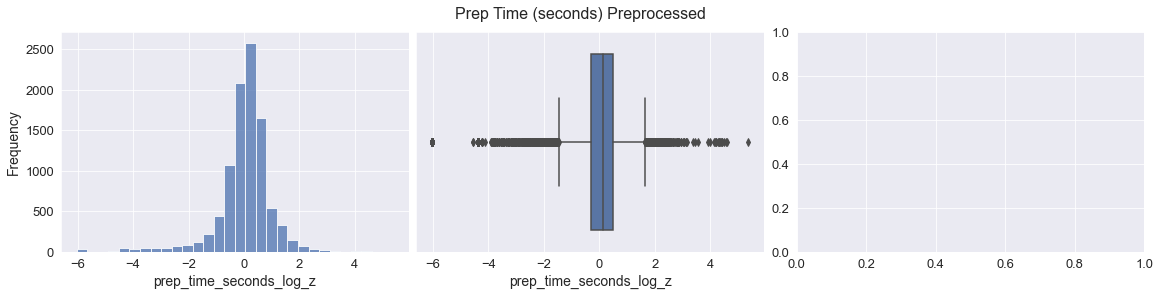

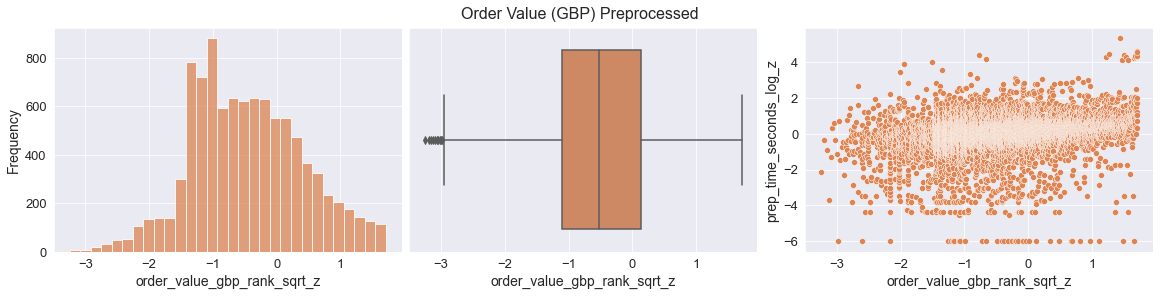

In [28]:
# Transforming numerical variables
# Doing transformations to get closer to a normal distribution
test_df_preprocessed = sqrt_transform(rank_transform(test_df,varnames=["order_value_gbp"], plot=False), ["order_value_gbp_rank"], plot=False)
test_df_preprocessed = log_transform(test_df_preprocessed,varnames=["prep_time_seconds"], plot=False)
# Issue: the rank transform on the test data isnt done correctly - the ranks are recalculated but theyre supposed to be based on the training data. need to figure this out still.


# Normalising them
test_df_preprocessed, new_varnames, standardised_stats = standardise(df=test_df_preprocessed, varnames=["order_value_gbp_rank_sqrt", "prep_time_seconds_log"], provided_stats=True, stats_input=standardised_stats)
plotting_numerical_vars(df=test_df_preprocessed, title="Prep Time (seconds) Preprocessed", indvar="prep_time_seconds_log_z", colorint=0)
plotting_numerical_vars(df=test_df_preprocessed, title="Order Value (GBP) Preprocessed", indvar="order_value_gbp_rank_sqrt_z", depvar="prep_time_seconds_log_z", colorint=1)

# Capping outliers in the predictors
test_df_preprocessed = cappingOutliersOverNStdev(test_df_preprocessed, varnames=["order_value_gbp_rank_sqrt_z"], N=3)

# Setting rare labels
test_df_preprocessed = set_rare_labels(test_df_preprocessed, cat_vars, rare_labels)

# Encoding categorical variables
test_df_encoded = test_df_preprocessed.toPandas()

# Saving the string variables in seperate column
for var in cat_vars:
    test_df_encoded[var+"_string"] = test_df_encoded[var]
test_df_encoded["order_hour_map_str"] = test_df_encoded["order_hour_map"]

# Doing the transformations
def encoder_transform(pdf, encoders):
    for encoder in encoders:
        pdf = encoder.fit_transform(pdf) 
    return pdf

test_df_encoded = encoder_transform(test_df_encoded, allEncoders)

def findEncodedVars(columns):
    result = []
    for col in columns:
        if ((col[-2] == "_") | (col[-3] == "_")) and col[-1].isdigit(): result.append(col) 
    return result

encoded_cat_vars = findEncodedVars(test_df_encoded.columns)
print(encoded_cat_vars)
display(test_df_encoded)

# If a new label comes in the model would break

# Base model: Linear regression

In [29]:
num_vars = ["order_value_gbp_rank_sqrt_z", "prep_time_seconds_log_z"]

x_columns = encoded_cat_vars + num_vars
y_column = "prep_time_seconds_log_z"
x_columns.remove(y_column)

X_train, y_train = training_df_encoded[x_columns], training_df_encoded[y_column]
X_test, y_test = test_df_encoded[x_columns], test_df_encoded[y_column]
display(X_test)


,order_hour_map_0,order_hour_map_1,order_hour_map_2,city_0,city_1,country_0,country_1,country_2,type_of_food_0,type_of_food_1,type_of_food_2,order_dayofweek_0,order_dayofweek_1,order_dayofweek_2,order_value_gbp_rank_sqrt_z
0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,-3.000000
1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,-3.000000
2,0,1,0,0,1,0,0,1,0,0,2,0,1,1,-3.000000
3,0,1,0,0,1,0,0,1,0,1,0,1,0,0,-3.000000
4,0,1,0,0,1,0,0,1,0,1,1,1,0,0,-3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754,0,1,1,1,2,0,1,0,0,2,2,0,0,1,1.710330
9755,0,1,1,0,1,0,0,1,0,2,2,1,1,0,1.711836
9756,0,0,1,0,1,0,0,1,0,2,2,1,1,1,1.713343
9757,0,0,1,0,1,0,0,1,2,0,2,1,1,1,1.714848


In [30]:
## REGRESSION
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

##Code for the linear regression model
X_train_sm = sm.add_constant(X_train) ## Adding an intercept (beta_0) to our model - to give the constant
linear_model = sm.OLS(y_train, X_train_sm).fit() ## sm.OLS(dependant, predictors)
y_train_pred = linear_model.predict(X_train_sm)

## Print out the statistics
print('Linear Model Table:')
display(linear_model.summary()) ##Report coefficients and Rsquared

rmse_train = rmse(y_train, y_train_pred)
r_squared_train = r2_score(y_train, y_train_pred)
print("RMSE: ", rmse_train)
print("R-squared:", r_squared_train)


# assumptions of a linear model: residuals normally distributed, predictors normally distributed, variance constant
#   residuals variance, independence, linear relationship between independent and dep vars, homoscedastiy 


Linear Model Table:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     prep_time_seconds_log_z   R-squared:                       0.204
Model:                                 OLS   Adj. R-squared:                  0.203
Method:                      Least Squares   F-statistic:                     385.6
Date:                     Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                             15:13:44   Log-Likelihood:                -27078.
No. Observations:                    22635   AIC:                         5.419e+04
Df Residuals:                        22619   BIC:                         5.432e+04
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           3.0266      0.095     31.882      0.000       2.840       3.213
order_hour_map_0               -1.6926      0.072    -23.468      0.000      -1.834      -1.551
order_hour_map_1                0.1978      0.014     13.847      0.000       0.170       0.226
order_hour_map_2               -1.8087      0.071    -25.494      0.000      -1.948      -1.670
city_0                          0.1452      0.015      9.553      0.000       0.115       0.175
city_1                          0.0378      0.017      2.164      0.030       0.004       0.072
country_0                      -1.4584      0.092    -15.833      0.000      -1.639      -1.278
country_1                      -1.2725      0.037    -34.370      0.000      -1.345      -1.200
country_2                      -1.3343      0.059    -22.768      0.000      -1.449      -1.219
type_of_food_0                  0.0151      0.009      1.678      0.093      -0.003       0.033
type_of_food_1                 -0.0245      0.007     -3.686      0.000      -0.037      -0.011
type_of_food_2                  0.0721      0.008      9.506      0.000       0.057       0.087
order_dayofweek_0              -0.0143      0.011     -1.288      0.198      -0.036       0.007
order_dayofweek_1              -0.0055      0.011     -0.490      0.624      -0.027       0.016
order_dayofweek_2              -0.0196      0.011     -1.763      0.078      -0.041       0.002
order_value_gbp_rank_sqrt_z     0.2280      0.005     41.848      0.000       0.217       0.239
==============================================================================
Omnibus:                     2987.569   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11222.780
Skew:                          -0.634   Prob(JB):                         0.00
Kurtosis:                       6.208   Cond. No.                         69.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RMSE:  0.8003997602405057
R-squared: 0.20365319345054989


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


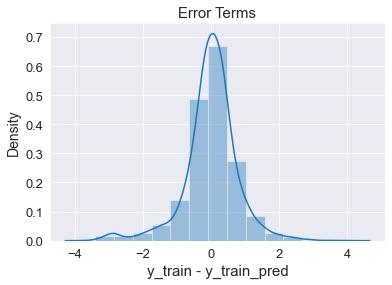

In [31]:
# Need to check residuals are normally distributed as thats an assumption of a linear model
residuals = (y_train - y_train_pred)
fig = plt.figure()
sns.distplot(residuals, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

### Evaluating on test dataset

In [32]:

X_test_sm = sm.add_constant(X_test)
y_test_pred = linear_model.predict(X_test_sm)

# Checking the R-squared value
rmse_test = rmse(y_test, y_test_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print("RMSE: ", rmse_test)
print("R-squared:", r_squared_test)
# whyy is it negative

RMSE:  1.7626192065664323
R-squared: -2.1271794631853345


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


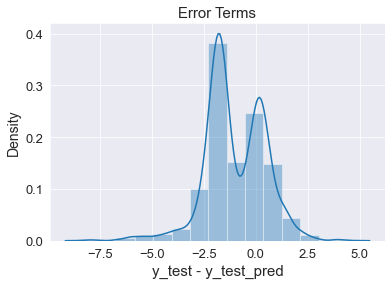

In [33]:
# Need to check residuals are normally distributed as thats an assumption of a linear model
residuals = (y_test - y_test_pred)
fig = plt.figure()
sns.distplot(residuals, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_test - y_test_pred', fontsize = 15)
plt.show()

Should have a different tree-based model in between here as a reference

# Using different model: XGBoost
XGBoost is also a tree-based ensemble supervised learning algorithm, that uses a gradient boosting framework. The intuition behind this algorithm is that it tries to fit the new predictor to residual errors made by the previous predictor. It is extremely fast, scalable, and portable.

Sources:
* [Regression Analysis for Beginners — Part 2](https://towardsdatascience.com/regression-analysis-for-beginners-using-tree-based-methods-2b65bd193a7#d410)
* [DataCamp Python tutorial on XGBoost](https://www.datacamp.com/community/tutorials/xgboost-in-python)

Sequential runs where it learns each time placing emphasis on what it gets wrong, whilst random forest trains the models in parallel

In [34]:
# !brew install libomp
# !pip3 install xgboost

import xgboost as xgb


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [35]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

y_train_pred = xg_reg.predict(X_train)
rmse_train_xg = rmse(y_train, y_train_pred)
print("Training RMSE: ", rmse_train_xg)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training RMSE:  0.8585289099011122


In [36]:
y_test_pred = xg_reg.predict(X_test)
rmse_test_xg = rmse(y_test, y_test_pred)
print("Test RMSE: ", rmse_test_xg)

Test RMSE:  1.0359516171367935


RMSE is a metric that tells us the average distance between the predicted values from the model and the actual values in the dataset.
The lower the RMSE, the better a given model is able to “fit” a dataset.

The RMSE for XGBoost is significantly better than for Linear regression. We can try to further improve it by tuning the hyperparameters through cross validation.

## Cross-validation

In [37]:
all_data_X = pd.concat([X_train, X_test])
all_data_y = pd.concat([y_train, y_test])

data_dmatrix = xgb.DMatrix(data=all_data_X,label=all_data_y) #XGBoost needs a Dmatrix data structure

params = {"objective":"reg:squarederror",'colsample_bylevel': 0.5,'learning_rate': 0.2,
                'max_depth': 5, 'alpha': 20}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=rand_seed)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.983534,0.002677,0.984017,0.025432
1,0.940007,0.002848,0.941118,0.025565
2,0.910472,0.002495,0.911885,0.026287
3,0.889423,0.002479,0.891480,0.026382
4,0.874988,0.002911,0.877583,0.026339


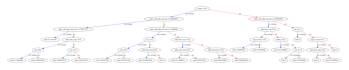

In [38]:
# !pip3 install graphviz
# !brew install graphviz

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [80, 20]
plt.show()

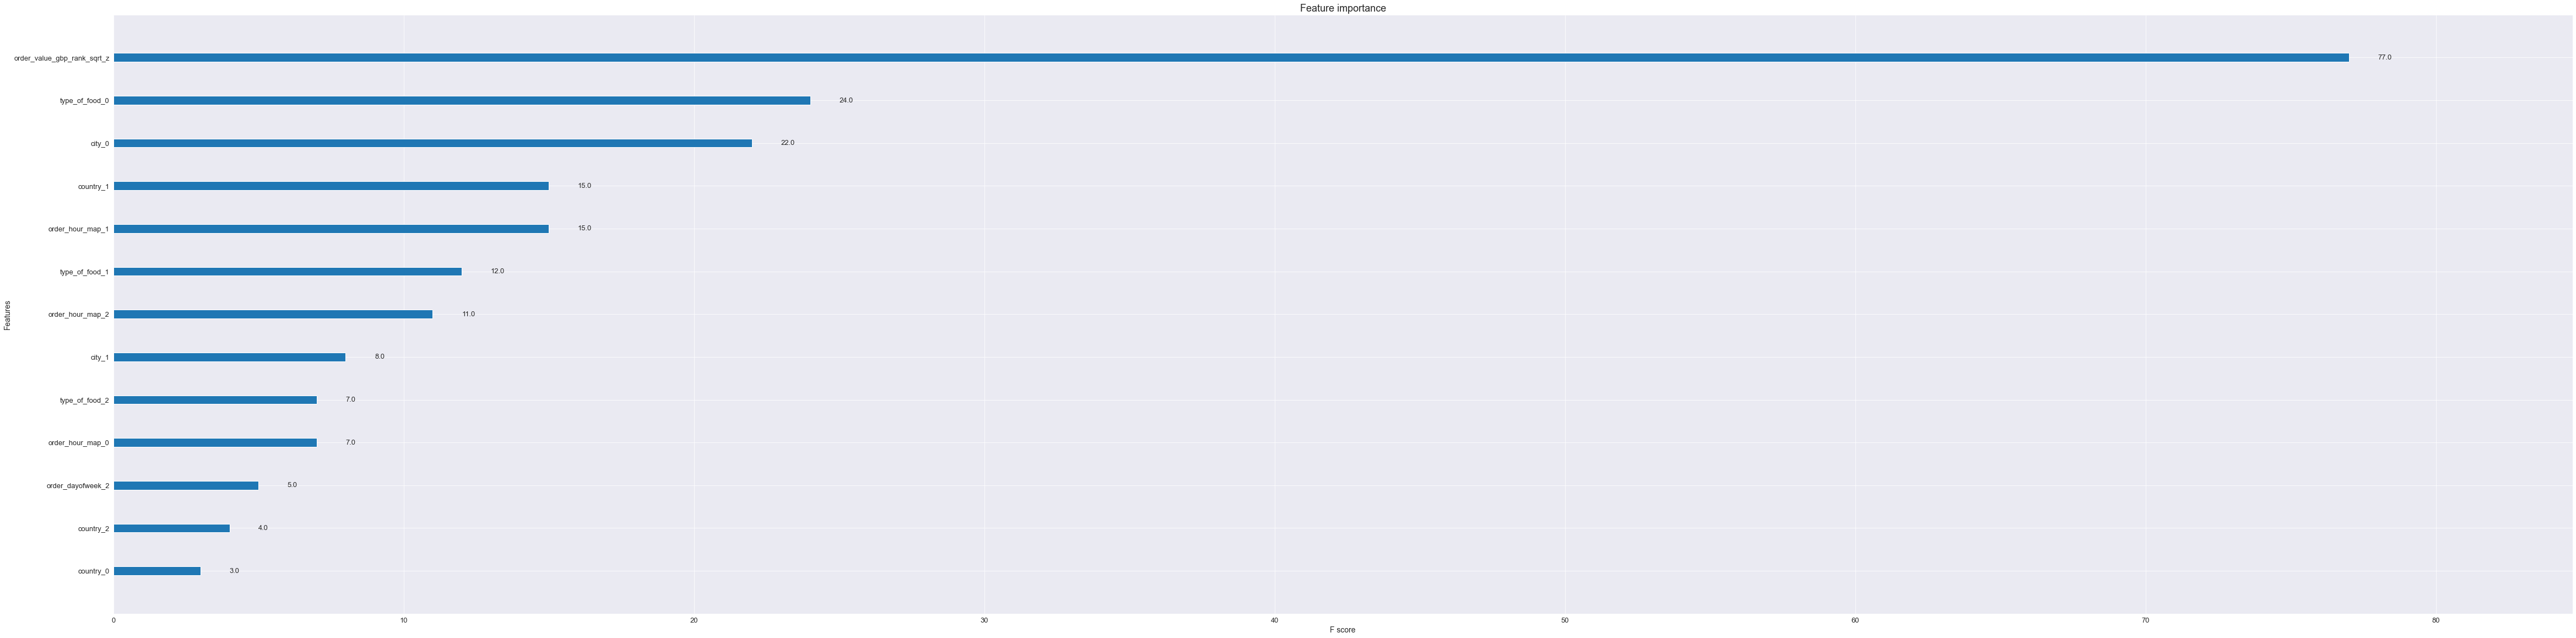

In [39]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 10]
plt.show()

The F-score is a metric that simply sums up how many times each feature is split on.

We see that day of week ranks the lowest, and order value the highest. Type of food and country also has high importance.

## Hyper-parameter tuning: Grid-search

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', seed = rand_seed)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Lowest RMSE:  0.920805472292768


In [42]:
# How would i explain this models performance to a stakeholder? E.g. could i figure out how many minutes/seconds off the model is in its predictions by transfomring variables back